Download neede libraries


import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the path to your dataset
dataset_path = "/content/drive/My Drive/Colab Notebooks/MRI_Scan"  # Adjust this path based on your folder location

# Check the folder structure
print("Contents of dataset:", os.listdir(dataset_path))

Contents of dataset: ['Training', 'Testing']


# Configuarations:

In [ ]:
config = {
    "batch_size": 32,  # Batch size for training/testing
    "learning_rate": 0.001,  # Learning rate for Adam optimizer
    "optimizer": "Adam",  # Optimizer choice
    "dropout": False,  # Your current model does not use dropout
    "num_epochs": 10,  # Number of training epochs
    "image_size": (224, 224),  # Matches the transformations applied in your pipeline
    "num_classes": 4,  # Number of tumor classes
    "device": "cpu",
    "dataset_path": "/content/drive/My Drive/Colab Notebooks/MRI_Scan",  # Updated dataset path
    "train_path": "/content/drive/My Drive/Colab Notebooks/MRI_Scan/Training",
    "test_path": "/content/drive/My Drive/Colab Notebooks/MRI_Scan/Testing",
    "normalize_mean": [0.485, 0.456, 0.406],  # Standard ImageNet mean
    "normalize_std": [0.229, 0.224, 0.225],  # Standard ImageNet std
    "augmentation": {
        "random_flip": True,  # Applies RandomHorizontalFlip
        "random_rotation": 10,  # Applies RandomRotation (±10 degrees)
    }
}

In [ ]:
#Transformations (augmentation & normalization)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["normalize_mean"], std=config["normalize_std"])
])


# Data Handling
## we use data loaders from pytorch

"""
You use dataloaders to split data into batches, shuffle data, or transform existing data on the fly.

Map-style datasets provide random-access capbilities. Examples: Numpy arrays, Python dicts, files on disk.

Iterable-style dataset can only be accessed sequentially. Examples: Python generators, streamed data from network.
"""

In [ ]:

# Load the training and testing datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/Training", transform=data_transforms)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/Testing", transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check dataset classes
print("Classes:", train_dataset.classes)
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of training samples: 5722
Number of testing samples: 1217


In [ ]:
class_names = train_dataset.classes

# Print the class names
print("Categorical class names:", class_names)

# Optionally print the class-to-index mapping (useful for later)
print("Class to index mapping:", train_dataset.class_to_idx)

Categorical class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class to index mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Visualization

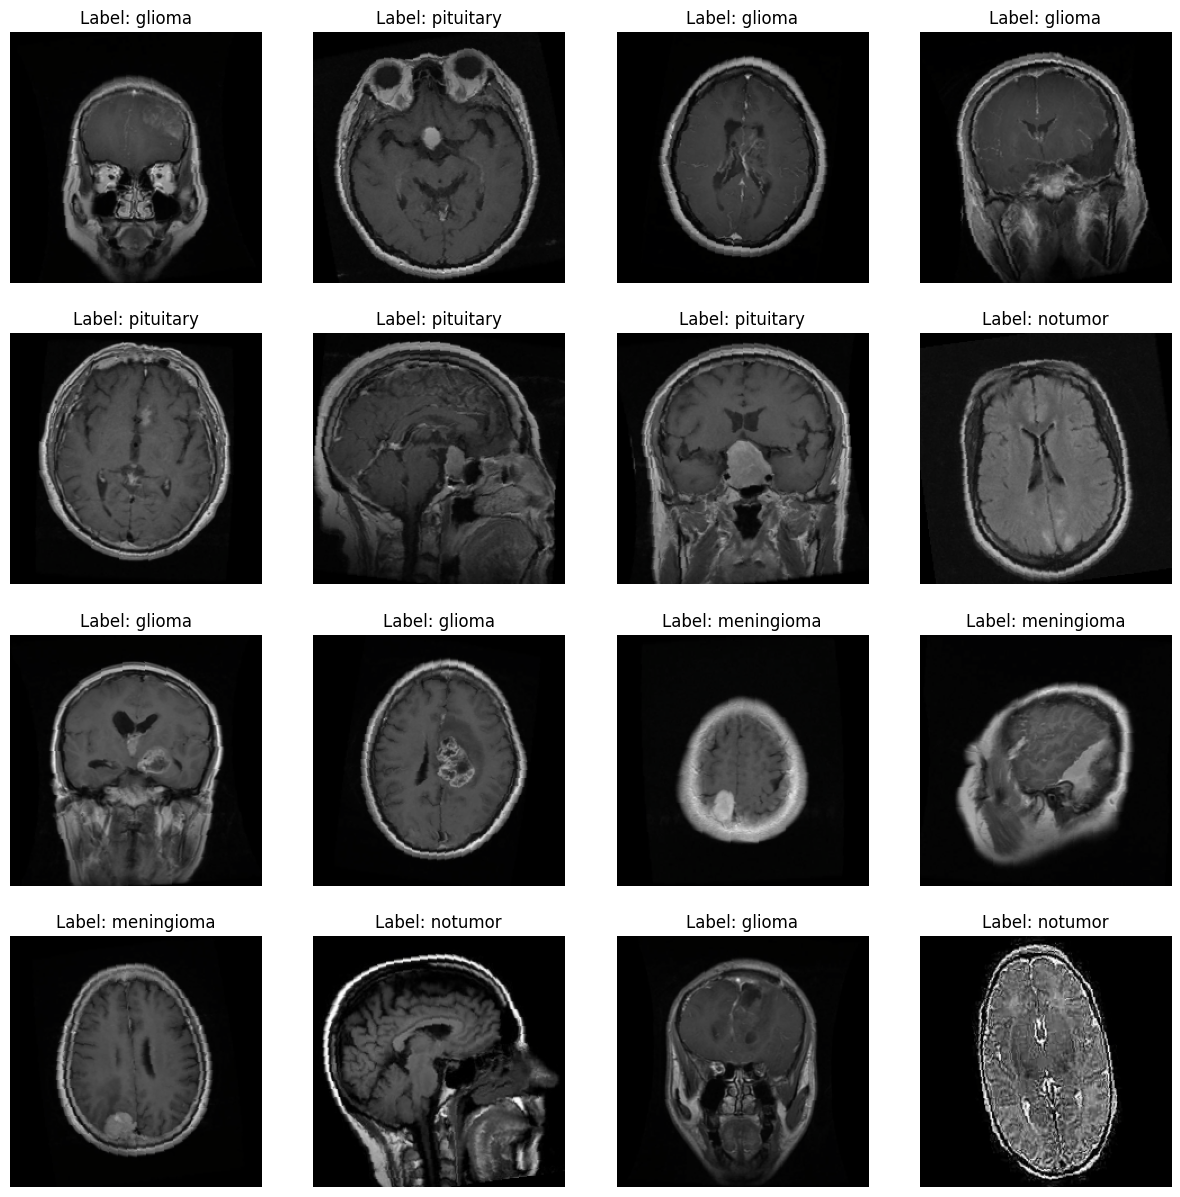

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = config["normalize_mean"]
std = config["normalize_std"]
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f"Label: {train_dataset.classes[labels[i]]}")
        ax.axis('off')

# Brain tumour classification model

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
            super(BrainTumorCNN, self).__init__()
            self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = BrainTumorCNN(num_classes=4)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Initialize lists to store training history
train_losses = []
test_losses = []

train_accuracy = []
test_accuracy = []

train_precision = []
test_precision = []

train_recall = []
test_recall = []

train_f1 = []
test_f1 = []

# Initialize best test accuracy for saving best model
best_test_accuracy = 0.0

# Number of epochs
num_epochs = config["num_epochs"]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    all_train_preds = []
    all_train_labels = []

    # Use tqdm to track progress
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (inputs, labels) in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  # Fix loss accumulation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Compute final training loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # Compute Precision, Recall, and F1-score for training
    train_prec = precision_score(all_train_labels, all_train_preds, average="weighted", zero_division=0)
    train_rec = recall_score(all_train_labels, all_train_preds, average="weighted", zero_division=0)
    train_f1_score = f1_score(all_train_labels, all_train_preds, average="weighted", zero_division=0)

    train_precision.append(train_prec)
    train_recall.append(train_rec)
    train_f1.append(train_f1_score)

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    # Compute final test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

    # Compute Precision, Recall, and F1-score for testing
    test_prec = precision_score(all_test_labels, all_test_preds, average="weighted", zero_division=0)
    test_rec = recall_score(all_test_labels, all_test_preds, average="weighted", zero_division=0)
    test_f1_score = f1_score(all_test_labels, all_test_preds, average="weighted", zero_division=0)

    test_precision.append(test_prec)
    test_recall.append(test_rec)
    test_f1.append(test_f1_score)

    # Save the best model based on test accuracy
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ Best model updated and saved!")

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy[-1] * 100:.2f}%")
    print(f"Train Precision: {train_precision[-1]:.4f} | Train Recall: {train_recall[-1]:.4f} | Train F1: {train_f1[-1]:.4f}")
    print(f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracy[-1] * 100:.2f}%")
    print(f"Test Precision: {test_precision[-1]:.4f} | Test Recall: {test_recall[-1]:.4f} | Test F1: {test_f1[-1]:.4f}")



Epoch [1/10]: 100%|██████████| 358/358 [29:35<00:00,  4.96s/it, acc=77.1, loss=0.558]


✅ Best model updated and saved!
Epoch 1/10:
Train Loss: 0.7680 | Train Acc: 77.11%
Train Precision: 0.7675 | Train Recall: 0.7711 | Train F1: 0.7683
Test Loss: 0.4156 | Test Acc: 84.63%
Test Precision: 0.8466 | Test Recall: 0.8463 | Test F1: 0.8386


Epoch [2/10]: 100%|██████████| 358/358 [04:15<00:00,  1.40it/s, acc=88.1, loss=0.189]


✅ Best model updated and saved!
Epoch 2/10:
Train Loss: 0.3202 | Train Acc: 88.06%
Train Precision: 0.8795 | Train Recall: 0.8806 | Train F1: 0.8800
Test Loss: 0.2515 | Test Acc: 90.88%
Test Precision: 0.9083 | Test Recall: 0.9088 | Test F1: 0.9083


Epoch [3/10]: 100%|██████████| 358/358 [04:49<00:00,  1.24it/s, acc=92.4, loss=0.0793]


✅ Best model updated and saved!
Epoch 3/10:
Train Loss: 0.2249 | Train Acc: 92.43%
Train Precision: 0.9243 | Train Recall: 0.9243 | Train F1: 0.9243
Test Loss: 0.2027 | Test Acc: 92.19%
Test Precision: 0.9230 | Test Recall: 0.9219 | Test F1: 0.9224


Epoch [4/10]: 100%|██████████| 358/358 [04:42<00:00,  1.27it/s, acc=94.4, loss=0.0378]


✅ Best model updated and saved!
Epoch 4/10:
Train Loss: 0.1592 | Train Acc: 94.41%
Train Precision: 0.9442 | Train Recall: 0.9441 | Train F1: 0.9441
Test Loss: 0.1831 | Test Acc: 94.17%
Test Precision: 0.9430 | Test Recall: 0.9417 | Test F1: 0.9411


Epoch [5/10]: 100%|██████████| 358/358 [04:43<00:00,  1.26it/s, acc=95.7, loss=0.00936]


✅ Best model updated and saved!
Epoch 5/10:
Train Loss: 0.1276 | Train Acc: 95.74%
Train Precision: 0.9574 | Train Recall: 0.9574 | Train F1: 0.9573
Test Loss: 0.1199 | Test Acc: 95.97%
Test Precision: 0.9596 | Test Recall: 0.9597 | Test F1: 0.9595


Epoch [6/10]: 100%|██████████| 358/358 [04:39<00:00,  1.28it/s, acc=96.9, loss=0.0717]


Epoch 6/10:
Train Loss: 0.0875 | Train Acc: 96.85%
Train Precision: 0.9686 | Train Recall: 0.9685 | Train F1: 0.9686
Test Loss: 0.2302 | Test Acc: 92.28%
Test Precision: 0.9308 | Test Recall: 0.9228 | Test F1: 0.9190


Epoch [7/10]: 100%|██████████| 358/358 [04:41<00:00,  1.27it/s, acc=96.6, loss=0.112]


Epoch 7/10:
Train Loss: 0.0956 | Train Acc: 96.64%
Train Precision: 0.9664 | Train Recall: 0.9664 | Train F1: 0.9664
Test Loss: 0.1559 | Test Acc: 95.73%
Test Precision: 0.9577 | Test Recall: 0.9573 | Test F1: 0.9565


Epoch [8/10]: 100%|██████████| 358/358 [04:43<00:00,  1.26it/s, acc=97.6, loss=0.0939]


✅ Best model updated and saved!
Epoch 8/10:
Train Loss: 0.0695 | Train Acc: 97.55%
Train Precision: 0.9756 | Train Recall: 0.9755 | Train F1: 0.9756
Test Loss: 0.1323 | Test Acc: 96.30%
Test Precision: 0.9636 | Test Recall: 0.9630 | Test F1: 0.9624


Epoch [9/10]: 100%|██████████| 358/358 [04:43<00:00,  1.26it/s, acc=98.4, loss=0.108]


✅ Best model updated and saved!
Epoch 9/10:
Train Loss: 0.0482 | Train Acc: 98.39%
Train Precision: 0.9840 | Train Recall: 0.9839 | Train F1: 0.9839
Test Loss: 0.1061 | Test Acc: 97.45%
Test Precision: 0.9746 | Test Recall: 0.9745 | Test F1: 0.9743


Epoch [10/10]: 100%|██████████| 358/358 [04:48<00:00,  1.24it/s, acc=98.5, loss=0.000261]


✅ Best model updated and saved!
Epoch 10/10:
Train Loss: 0.0468 | Train Acc: 98.53%
Train Precision: 0.9853 | Train Recall: 0.9853 | Train F1: 0.9853
Test Loss: 0.0819 | Test Acc: 97.53%
Test Precision: 0.9753 | Test Recall: 0.9753 | Test F1: 0.9753


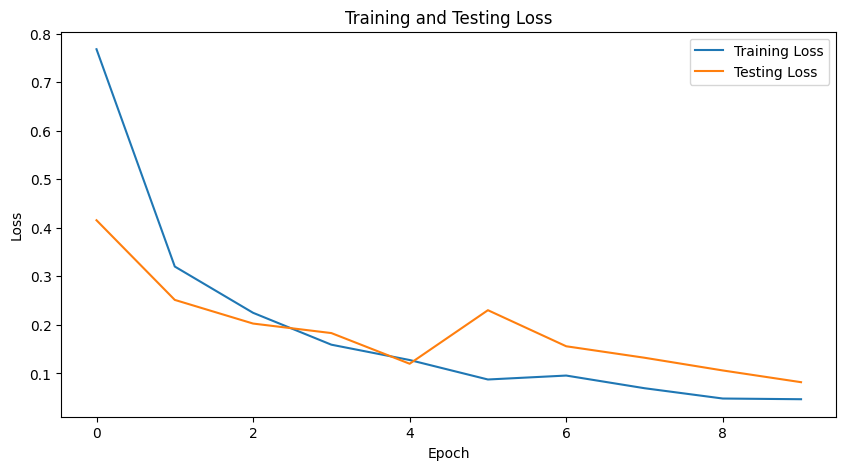

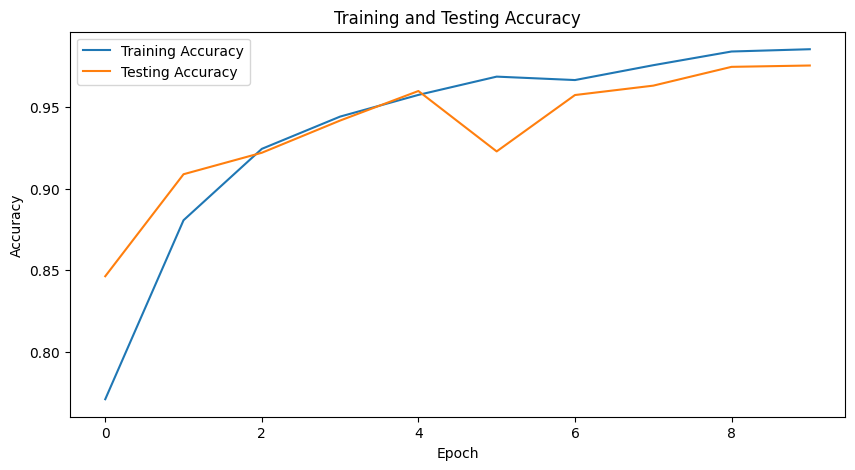

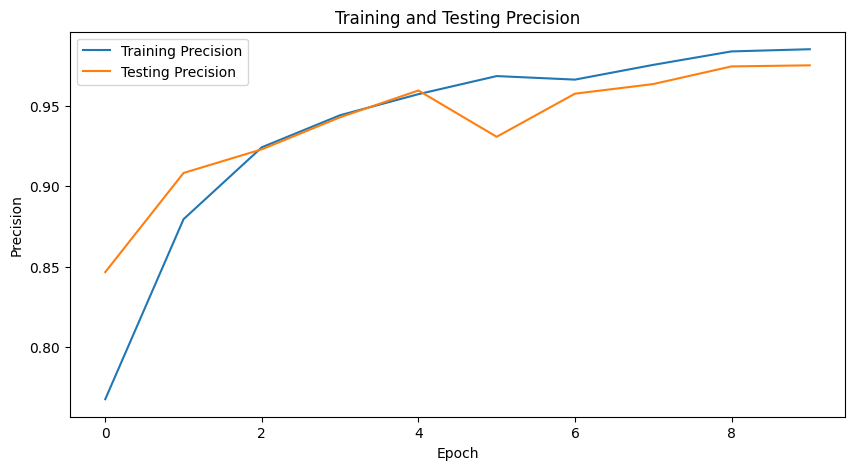

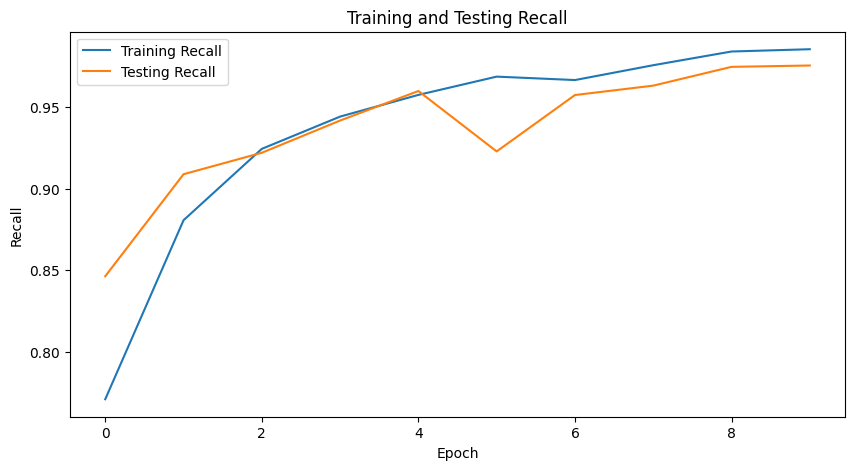

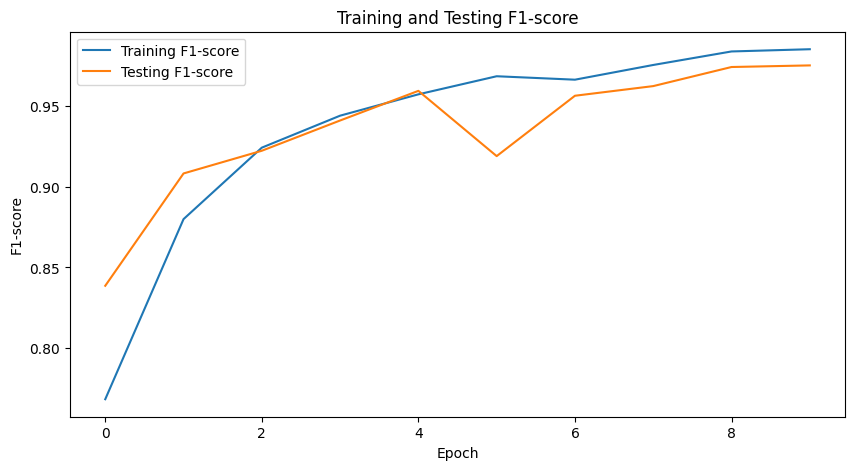

In [ ]:

import matplotlib.pyplot as plt
# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

#Plot training and testing precision
plt.figure(figsize=(10, 5))
plt.plot(train_precision, label='Training Precision')
plt.plot(test_precision, label='Testing Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Testing Precision')
plt.legend()
plt.show()

# Plot training and testing recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall, label='Training Recall')
plt.plot(test_recall, label='Testing Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Testing Recall')
plt.legend()
plt.show()

# Plot training and testing f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1, label='Training F1-score')
plt.plot(test_f1, label='Testing F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Training and Testing F1-score')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Create a list of dictionaries, where each dictionary represents an epoch's data
performance_data = []
for epoch in range(num_epochs):
  performance_data.append({
      "Epoch": epoch + 1,
      "Train Loss": train_losses[epoch],
      "Test Loss": test_losses[epoch],
      "Train Accuracy": train_accuracy[epoch],
      "Test Accuracy": test_accuracy[epoch],
      "Train Precision": train_precision[epoch],
      "Test Precision": test_precision[epoch],
      "Train Recall": train_recall[epoch],
      "Test Recall": test_recall[epoch],
      "Train F1": train_f1[epoch],
      "Test F1": test_f1[epoch]
  })

# Create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(performance_data)

# Display the DataFrame
df


,Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
0,1,0.767955,0.415586,0.771059,0.846343,0.767484,0.846599,0.771059,0.846343,0.768262,0.838619
1,2,0.320208,0.251456,0.880636,0.908792,0.879526,0.908309,0.880636,0.908792,0.879953,0.908276
2,3,0.224876,0.202714,0.924327,0.921939,0.924292,0.923026,0.924327,0.921939,0.924276,0.922355
3,4,0.159176,0.183114,0.944075,0.941660,0.944249,0.942979,0.944075,0.941660,0.944108,0.941115
4,5,0.127594,0.119914,0.957358,0.959737,0.957350,0.959636,0.957358,0.959737,0.957345,0.959499
5,6,0.087460,0.230244,0.968542,0.922761,0.968610,0.930822,0.968542,0.922761,0.968559,0.919029
6,7,0.095583,0.155928,0.966445,0.957272,0.966411,0.957656,0.966445,0.957272,0.966426,0.956467
7,8,0.069498,0.132283,0.975533,0.963024,0.975587,0.963638,0.975533,0.963024,0.975550,0.962450
8,9,0.048246,0.106090,0.983922,0.974528,0.983965,0.974632,0.983922,0.974528,0.983937,0.974286
9,10,0.046818,0.081916,0.985320,0.975349,0.985325,0.975295,0.985320,0.975349,0.985319,0.975285


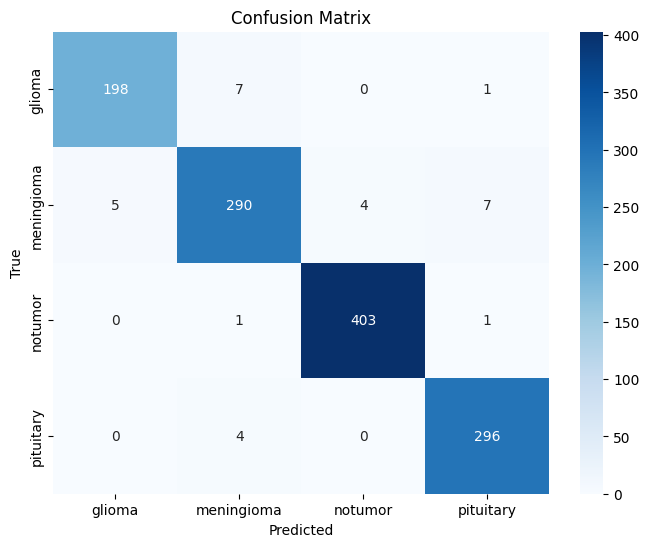

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming all_test_preds and all_test_labels are defined from your previous code

cm = confusion_matrix(all_test_labels, all_test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
